In [1]:
%load_ext jupyter_ai_magics

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
import umap
import torch, os, scipy
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mateowheeler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [4]:
emb1 = model.encode("This wine has hints of fresh tennis ball.")
emb2 = model.encode("This wine has hints of a bowling alley.")

In [5]:
cos_sim = util.cos_sim(emb1, emb2)
print("Cosine-Similarity:", cos_sim)

Cosine-Similarity: tensor([[0.6378]])


In [6]:
df0 = pd.read_csv('data/winemag-data_first150k.csv')
df1 = pd.read_csv('data/winemag-data-130k-v2.csv')

df = pd.concat([df0,df1], ignore_index=True)

In [7]:
df.dtypes

Unnamed: 0                 int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
variety                   object
winery                    object
taster_name               object
taster_twitter_handle     object
title                     object
dtype: object

In [8]:
df.groupby('country')\
    .agg({'taster_name':'nunique', 
          'winery':'nunique', 
          'title':'nunique',
          'points':'mean',
          'price':'mean'})\
    .reset_index()

,country,taster_name,winery,title,points,price
0,Albania,0,1,0,88.000000,20.000000
1,Argentina,1,647,3543,86.283851,22.288451
2,Armenia,1,1,2,87.500000,14.500000
3,Australia,2,646,2183,88.112407,32.592237
4,Austria,2,254,3022,89.707591,30.964597
5,Bosnia and Herzegovina,2,1,2,85.333333,12.666667
6,Brazil,1,13,49,84.207792,22.430556
7,Bulgaria,4,28,132,87.064220,13.550459
8,Canada,6,50,226,88.880795,35.243304
9,Chile,3,357,4178,86.382290,19.970045


#### Filter for Italian wine reviews

In [9]:
df_filtered = df[df.country=='Italy'].reset_index()

In [10]:
len(df_filtered)

43018

#### Pre-process Description

In [14]:
stop = stopwords.words('english')
new_stopwords = ('wine','aromas')

for i in new_stopwords:
    stop.append(i)
print(stop)

df_filtered['desc_without_stopwords'] = df_filtered['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_filtered['desc_without_stopwords']

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

0        Elegance, complexity structure come together d...
1        Underbrush, scorched earth, menthol plum steep...
2        Forest floor, tilled soil, mature berry whiff ...
3        Aromas forest floor, violet, red berry whiff d...
4        This charming nose boasts rose, violet red ber...
                               ...                        
43013    This luminous sparkler sweet, fruit-forward no...
43014    A blend Nero d'Avola Syrah, conveys scorched e...
43015    A blend 65% Cabernet Sauvignon, 30% Merlot 5% ...
43016    Intense wild cherry, baking spice, tilled soil...
43017    Blackberry, cassis, grilled herb toasted come ...
Name: desc_without_stopwords, Length: 43018, dtype: object

In [15]:
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatize verbs in descriptions
new_descs = []
for desc in df_filtered['desc_without_stopwords']:
    new_desc = []
    for w_desc in desc:
        new_desc.append(wordnet_lemmatizer.lemmatize(w_desc, pos="v"))
    new_descs.append(new_desc) 

df_filtered['desc_without_stopwords_lemm'] = new_descs
df_filtered['desc_without_stopwords_lemm'] = [' '.join(i) for i in df_filtered['desc_without_stopwords_lemm']]

pd.set_option('display.max_colwidth', None)
df_filtered[['desc_without_stopwords','desc_without_stopwords_lemm']]

,desc_without_stopwords,desc_without_stopwords_lemm
0,"Elegance, complexity structure come together drop-dead gorgeous winethat ranks among Italy's greatest whites. It opens sublime yellow spring flower, aromatic herb orchard fruit scents. The creamy, delicious palate seamlessly combines juicy white peach, ripe pear citrus flavors white almond savory mineral notes grace lingering finish.","E l e g a n c e , c o m p l e x i t y s t r u c t u r e c o m e t o g e t h e r d r o p - d e a d g o r g e o u s w i n e t h a t r a n k s a m o n g I t a l y ' s g r e a t e s t w h i t e s . I t o p e n s s u b l i m e y e l l o w s p r i n g f l o w e r , a r o m a t i c h e r b o r c h a r d f r u i t s c e n t s . T h e c r e a m y , d e l i c i o u s p a l a t e s e a m l e s s l y c o m b i n e s j u i c y w h i t e p e a c h , r i p e p e a r c i t r u s f l a v o r s w h i t e a l m o n d s a v o r y m i n e r a l n o t e s g r a c e l i n g e r i n g f i n i s h ."
1,"Underbrush, scorched earth, menthol plum steeped spirits unfold glass. The big, chewy palate doles ripe wild cherry, raspberry jam, ground pepper licorice alongside firm, velvety tannins. You'll also detect warmth alcohol finish.","U n d e r b r u s h , s c o r c h e d e a r t h , m e n t h o l p l u m s t e e p e d s p i r i t s u n f o l d g l a s s . T h e b i g , c h e w y p a l a t e d o l e s r i p e w i l d c h e r r y , r a s p b e r r y j a m , g r o u n d p e p p e r l i c o r i c e a l o n g s i d e f i r m , v e l v e t y t a n n i n s . Y o u ' l l a l s o d e t e c t w a r m t h a l c o h o l f i n i s h ."
2,"Forest floor, tilled soil, mature berry whiff new leather combine this. The ripe palate offers fleshy black cherry, dried aromatic herb tobacco, fine-grained tannins give finish grip. Drink 2018–2023.","F o r e s t f l o o r , t i l l e d s o i l , m a t u r e b e r r y w h i f f n e w l e a t h e r c o m b i n e t h i s . T h e r i p e p a l a t e o f f e r s f l e s h y b l a c k c h e r r y , d r i e d a r o m a t i c h e r b t o b a c c o , f i n e - g r a i n e d t a n n i n s g i v e f i n i s h g r i p . D r i n k 2 0 1 8 – 2 0 2 3 ."
3,"Aromas forest floor, violet, red berry whiff dark baking spice unfold glass wild cherry, black raspberry, ground pepper star anise drive palate. Framed firm, fine-grained tannins, classic Tuscan red. Drink 2020.","A r o m a s f o r e s t f l o o r , v i o l e t , r e d b e r r y w h i f f d a r k b a k i n g s p i c e u n f o l d g l a s s w i l d c h e r r y , b l a c k r a s p b e r r y , g r o u n d p e p p e r s t a r a n i s e d r i v e p a l a t e . F r a m e d f i r m , f i n e - g r a i n e d t a n n i n s , c l a s s i c T u s c a n r e d . D r i n k 2 0 2 0 ."
4,"This charming nose boasts rose, violet red berry juicy, easy-drinking palate offers ripe wild cherry, chopped mint, white pepper hint star anise. There much complexity savory balanced, fresh acidity supple tannins.","T h i s c h a r m i n g n o s e b o a s t s r o s e , v i o l e t r e d b e r r y j u i c y , e a s y - d r i n k i n g p a l a t e o f f e r s r i p e w i l d c h e r r y , c h o p p e d m i n t , w h i t e p e p p e r h i n t s t a r a n i s e . T h e r e m u c h c o m p l e x i t y s a v o r y b a l a n c e d , f r e s h a c i d i t y s u p p l e t a n n i n s ."
...,...,...
43013,"This luminous sparkler sweet, fruit-forward nose cool white peach, sliced banana cherry blossoms. There's slight note green grass distinguishable mineral tones add depth personality. In mouth creamy, soft texture vibrant fruit flavors.","T h i s l u m i n o u s s p a r k l e r s w e e t , f r u i t - f o r w a r d n o s e c o o l w h i t e p e a c h , s l i c e d b a n a n a c h e r r y b l o s s o m s . T h e r e ' s s l i g h t n o t e g r e e n g r a s s d i s t i n g u i s h a b l e m i n e r a l t o n e s a d d d e p t h p e r s o n a l i t y . I n m o u t h c r e a m y , s o f t t e x t u r e v i b r a n t f r u i t f l a v o r s ."
43014,

#### Lemmatizer is removing spaces between words, not working correctly, so use Description minus Stop Words for Corpus

In [16]:
corpus = df_filtered['desc_without_stopwords']
corpus

0        Elegance, complexity structure come together drop-dead gorgeous winethat ranks among Italy's greatest whites. It opens sublime yellow spring flower, aromatic herb orchard fruit scents. The creamy, delicious palate seamlessly combines juicy white peach, ripe pear citrus flavors white almond savory mineral notes grace lingering finish.
1                                                                                                                  Underbrush, scorched earth, menthol plum steeped spirits unfold glass. The big, chewy palate doles ripe wild cherry, raspberry jam, ground pepper licorice alongside firm, velvety tannins. You'll also detect warmth alcohol finish.
2                                                                                                                                               Forest floor, tilled soil, mature berry whiff new leather combine this. The ripe palate offers fleshy black cherry, dried aromatic herb tobacco, fine-grained tannins 

#### Create embeddings

In [17]:
corpus_embeddings = model.encode(corpus)
corpus_embeddings.shape

(43018, 384)

#### Cluster the embeddings

In [18]:
# disable tokeniser parallelization so kmeans works
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [19]:
K = 4
kmeans = KMeans(n_clusters=K,random_state=0).fit(corpus_embeddings)
cls_dist=pd.Series(kmeans.labels_).value_counts()

In [20]:
cls_dist

3    15529
2    11933
0     8933
1     6623
Name: count, dtype: int64

In [21]:
distances = scipy.spatial.distance.cdist(kmeans.cluster_centers_,corpus_embeddings)
centers={}
print("Cluster", "Size", "Center-idx","Center-Example", sep="\t\t")
for i,d in enumerate(distances):
    ind = np.argsort(d, axis=0)[0]
    centers[i]=ind
    print(i,cls_dist[i], ind, corpus[ind] ,sep="\t\t")

Cluster		Size		Center-idx		Center-Example
0		8933		30821		Bright refreshing, opens scents honeysuckle, jasmine, pear yellow stone fruit. The round lively palate offers peach, green apple hint white almond. Fresh acidity lifts rich flavors.
1		6623		25293		This blend Sangiovese, Ciliegiolo, Colorino, Canaiolo, Merlot Cabernet Sauvignon presents violet, wild berry spice aromas. The savory palate offers wild cherry, raspberry cinnamon-spice flavors. It simple, pleasant structure made easy drinking.
2		11933		42009		Smooth delicious, boasts enticing scents violet, berry, leather, tilled soil aromatic herb. The radiant, elegant palate offers ripe red cherry, crushed raspberry, white pepper licorice, note pipe tobacco closes finish. Polished tannins bright acidity provide balance structure. Drink 2018–2025.
3		15529		16207		This blend Sangiovese, Merlot Sagrantino simple, fruit-forward loads red cherry, blueberry, cedar wood exotic spice. It gritty, spicy mouthfeel big, powerful tannins.


#### Visualize clusters

[1 2 2 ... 1 2 2]
[2.5235066 8.926466  9.578179  ... 7.261478  8.912756  8.889352 ]


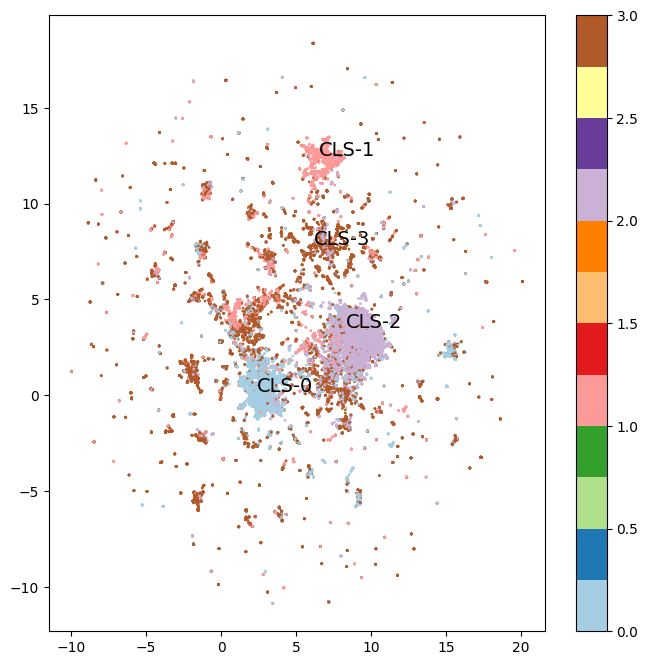

In [31]:
X = umap.UMAP(n_components=2,min_dist=0.0).fit_transform(corpus_embeddings)
labels= kmeans.labels_
print(labels)
fig, ax = plt.subplots(figsize=(8,8))
print(X[:,0])
plt.scatter(X[:,0], X[:,1], c=labels, s=1, cmap='Paired')
for c in centers:
    plt.text(X[centers[c],0], X[centers[c], 1],"CLS-"+ str(c), fontsize=14)
plt.colorbar()

In [23]:
# Add Cluster and embeddings as new columns in source dataframe
df_filtered['cluster'] = labels
df_filtered['embedding'] = corpus_embeddings.tolist()
df_filtered[['cluster','embedding','desc_without_stopwords']]

,cluster,embedding,desc_without_stopwords
0,1,"[0.02302243933081627, -0.007948293350636959, -0.0015214753802865744, 0.03150039166212082, 0.0445484034717083, 0.048911239951848984, 0.025983648374676704, -0.049806639552116394, 0.03153000771999359, -0.09469997137784958, -0.023921700194478035, 0.023511221632361412, -0.04614149034023285, 0.03816044703125954, 0.0037629196885973215, 0.07683844119310379, 0.05530792847275734, 0.006878506392240524, -0.032989099621772766, 0.034153200685977936, 0.049287065863609314, 0.0031859418377280235, -0.0048515452072024345, 0.01390540599822998, -0.007258143275976181, -0.008669016882777214, -0.005709677468985319, 0.04514387622475624, -0.024418307468295097, -0.032511550933122635, 0.038065437227487564, 0.12736375629901886, 0.0605928972363472, -0.021177345886826515, -0.05571332946419716, -0.047774799168109894, 0.08788111805915833, -0.13063853979110718, 0.03309809789061546, 0.02552344650030136, 0.02186959981918335, 0.09414570033550262, 0.028262635692954063, 0.08202289789915085, -0.025992700830101967, 0.03648827224969864, -0.016239026561379433, -0.006088889203965664, 0.003008190542459488, -0.031056173145771027, -0.041356198489665985, -0.03647559508681297, -0.030526669695973396, -0.07515823096036911, -0.03579964116215706, 0.07589131593704224, 0.00866706296801567, -0.00011392579472158104, 0.03832428529858589, -0.018947118893265724, 0.030196232721209526, -0.03125181421637535, 0.011969877406954765, -0.008718459866940975, -0.003525468986481428, 0.06452066451311111, -0.0993533656001091, 0.03184780478477478, -0.013596710748970509, -0.10420645773410797, 0.02034815214574337, -0.09197595715522766, -0.008592194877564907, 0.058925893157720566, -0.03536556661128998, 0.0888434499502182, 0.012218710966408253, -0.056430887430906296, -0.13558343052864075, -0.034888073801994324, -0.004307820927351713, 0.01692473329603672, -0.07730390131473541, 0.017773084342479706, 0.010032697580754757, 0.03036346472799778, 0.012779825367033482, -0.031246235594153404, 0.00028511404525488615, 0.0025580576620996, -0.019260648638010025, 0.01752653531730175, -0.12195849418640137, -0.07537179440259933, 0.013867752626538277, 0.03818519413471222, 0.05489560589194298, -0.04527396708726883, -0.06672264635562897, 0.06240946054458618, ...]","Elegance, complexity structure come together drop-dead gorgeous winethat ranks among Italy's greatest whites. It opens sublime yellow spring flower, aromatic herb orchard fruit scents. The creamy, delicious palate seamlessly combines juicy white peach, ripe pear citrus flavors white almond savory mineral notes grace lingering finish."
1,2,"[0.02341894991695881, -0.0925232470035553, 0.016246888786554337, 0.017913419753313065, 0.016430838033556938, 0.023415490984916687, -0.005328546278178692, -0.0920732393860817, -0.015172588638961315, -0.05377722159028053, -0.003376811044290662, -0.04533444344997406, -0.07145718485116959, 0.03545757010579109, 0.01681257225573063, -0.04895736277103424, 0.01785651221871376, 0.025445638224482536, 0.03882560133934021, -0.05210074409842491, 0.09239830076694489, 0.04312664270401001, -0.009221076034009457, -0.061980947852134705, -0.036913543939590454, 0.0426676869392395, -0.028518743813037872, -0.0026459170039743185, -0.01757938601076603, -0.09982169419527054, 0.09598253667354584, 0.06341271102428436, 0.09012284874916077, -0.07612574100494385, 0.02995912916958332, -0.010524574667215347, 0.08087582141160965, -0.04398158937692642, 0.09709436446428299, 0.017252346500754356, 0.015134105458855629, -0.051707614213228226, 0.056168802082538605, 0.045817919075489044, -0.010833867825567722, 0.01906365342438221, -0.016609730198979378, -0.024883871898055077, -0.021704357117414474, 0.005830350331962109, -0.005022904369980097, -0.03206867724657059, 0.01669429987668991, -0.023610860109329224, 0.01257067359983921, 0.026407836005091667, 0.017799269407987595, 0.004255745094269514, 0.08715453743934631, -0.00493191834539175, 0.018422693014144897, -0.009024436585605145, -0.0510556623339653, -0.0114384228363633

#### Top Words per Clusters

In [24]:
# initialize
cv = CountVectorizer(stop_words='english') 
cv_matrix = cv.fit_transform(df_filtered['desc_without_stopwords']) 
# create document term matrix
df_dtm = pd.DataFrame(
    cv_matrix.toarray(), 
    index=df_filtered['desc_without_stopwords'].values, 
    columns=cv.get_feature_names_out()
)

df_dtm['cluster'] = labels

df_dtm.index.name = '_desc_'
df_word_count = df_dtm.groupby('cluster').sum().reset_index().melt(
    id_vars=['cluster'], var_name='_word_', value_name='_count_'
)

In [25]:
words_0 = df_word_count[df_word_count.cluster==0].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_0.head(5)

,cluster,_word_,_count_
0,0,fruit,5191
1,0,white,3969
2,0,palate,3911
3,0,peach,3536
4,0,acidity,3016


In [26]:
words_1 = df_word_count[df_word_count.cluster==1].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_1.head(5)

,cluster,_word_,_count_
0,1,fruit,3076
1,1,cabernet,2959
2,1,sauvignon,2909
3,1,spice,2431
4,1,blend,2407


In [27]:
words_2 = df_word_count[df_word_count.cluster==2].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_2.head(5)

,cluster,_word_,_count_
0,2,palate,8855
1,2,tannins,8721
2,2,cherry,7997
3,2,black,6770
4,2,spice,4444


In [28]:
words_3 = df_word_count[df_word_count.cluster==3].sort_values(
    by=['_count_'], ascending=False).reset_index(drop=True)

words_3.head(5)

,cluster,_word_,_count_
0,3,fruit,7396
1,3,cherry,5496
2,3,spice,5317
3,3,offers,3351
4,3,bright,3320


#### Can we reccomend (predict) wines based on a human's previous wine choices and the corresponding description embeddings?